- 유윤식, 윤진수, 윤은성, 전송주, 최지훈
- 사용 모델: ResNet101

In [ ]:
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir = './drive/MyDrive/iTStudy/Deep_Learning/miniProject/model_saved/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- gpu 할당

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 파라미터 설정

In [ ]:
CFG = {
    'IMG_SIZE_H':800, #이미지 사이즈
    'IMG_SIZE_W':1200,
    'EPOCHS':150, #에포크
    'LEARNING_RATE':0.0001, #학습률
    'BATCH_SIZE':4, #배치사이즈
    'SCHEDULER':6,
    'PATIENCE':14
}

# 데이터 적제

In [ ]:
import gdown
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
fname = 'plant-pathology.zip'
gdown.download(url, fname, quiet=False)
!unzip plant-pathology.zip -d plant-pathology

Downloading...
From: https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8
To: /content/plant-pathology.zip
100%|██████████| 817M/817M [00:03<00:00, 270MB/s]


Archive:  plant-pathology.zip
replace plant-pathology/images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

파라미터 설정

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [ ]:
df_train = pd.read_csv('./plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [ ]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3

df_train['label'] = df_train['label'].apply(lambda x : int(x)) 

df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [ ]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [ ]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg'))) 
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))

    
    return img_path_list

In [ ]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [ ]:
for p, l in zip(all_img_path[:5], all_label[:5]):
    print(p, l)

./plant-pathology/images/Train_0.jpg 3
./plant-pathology/images/Train_1.jpg 1
./plant-pathology/images/Train_2.jpg 0
./plant-pathology/images/Train_3.jpg 2
./plant-pathology/images/Train_4.jpg 0


In [ ]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환 함수 설정.

In [ ]:
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): 
        img_path = self.img_path_list[index]
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [ ]:
# 데이터 편향을 생각을 못했습니다. - 추후 개선 -
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [ ]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# 이미지 확인

- Tensor로만 변환하여 이미지 확인

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor())

train_ds_ = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 

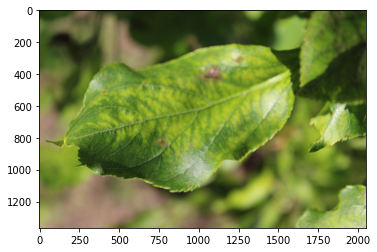

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

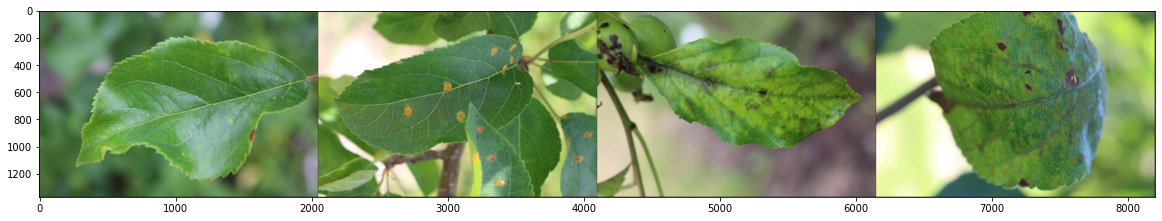

In [ ]:
def imshow(img):         
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_ds_)
dataiter.next()
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrows=8))
print(labels)

In [ ]:
print(images[0].shape) # C x H x W

torch.Size([3, 1365, 2048])


# 이미지 변환 준비
- Normalize를 위해
- 각 RGB의 mean과 std 를 구한다.

In [ ]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

meanR = round(np.mean([m[0] for m in train_meanRGB]),4)
meanG = round(np.mean([m[1] for m in train_meanRGB]),4)
meanB = round(np.mean([m[2] for m in train_meanRGB]),4)
stdR = round(np.std([s[0] for s in train_stdRGB]),4)
stdG = round(np.std([s[1] for s in train_stdRGB]),4)
stdB = round(np.std([s[2] for s in train_stdRGB]),4)

In [ ]:
print(f'meanR : {meanR}, meanG : {meanG}, meanB : {meanB}')
print(f'stdR : {stdR}, stdG : {stdG}, train_stdB : {stdB}')

meanR : 0.40619999170303345, meanG : 0.5149000287055969, meanB : 0.31290000677108765
stdR : 0.043299999088048935, stdG : 0.042500000447034836, train_stdB : 0.03759999945759773


# 이미지 변경

## albumentations

In [ ]:
# import albumentations as A
# from albumentations.pytorch import ToTensor
# import cv2

# train_transform = A.Compose([
#                             ToTensor(),
#                             A.Resize(CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']),
#                             A.HorizontalFlip(p=0.5),
#                             A.VerticalFlip(p=0.5),
#                             A.Rotate(limit=(0, 180), p=0.5, border_mode=cv2.BORDER_CONSTANT),
#                             A.CenterCrop(CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']),
#                             A.Normalize()
#                             ])

# vali_transform = A.Compose([
#                             ToTensor(),
#                             A.Resize(CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']),
#                             A.Normalize()
#                             ])

# test_transform = A.Compose([A.Resize(CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']),
#                             ToTensor(),
#                             A.Normalize()
#                             ])

## torchvision.transforms


- 사이즈 800, 1200
- 0.5 확률 좌우 대칭
- 0.5 확률 상하 대칭
- 0~180도 회전
- 확대
- 텐서로 변환

In [ ]:
from torchvision.transforms.transforms import RandomRotation
train_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']]), # 800 1200
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=(0, 180)),
                    transforms.CenterCrop((CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W'])),
                    transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                    ])

vali_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']]),
                    transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                    ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize([CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W']]),
                                     transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                                     ])

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=vali_transform) 

test_ds = CustomDataset(test_img_path, valid_label, train_mode=False, transforms=test_transform) 

In [ ]:
train_loader = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) # batch_size = 4
vali_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# 변환된 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


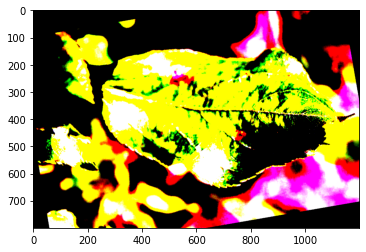

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [ ]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

342 114
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


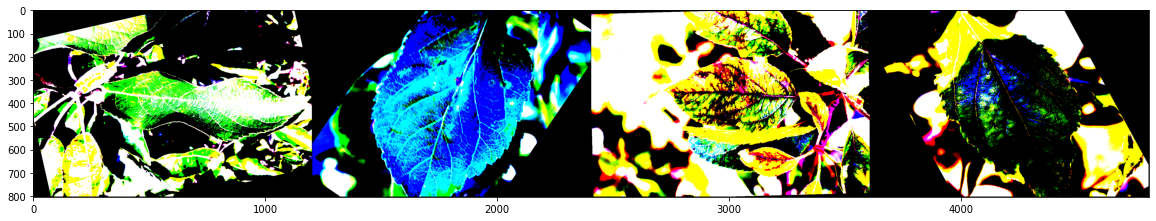

In [ ]:
def imshow(img):         
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images, nrows=8))

# 모델 생성

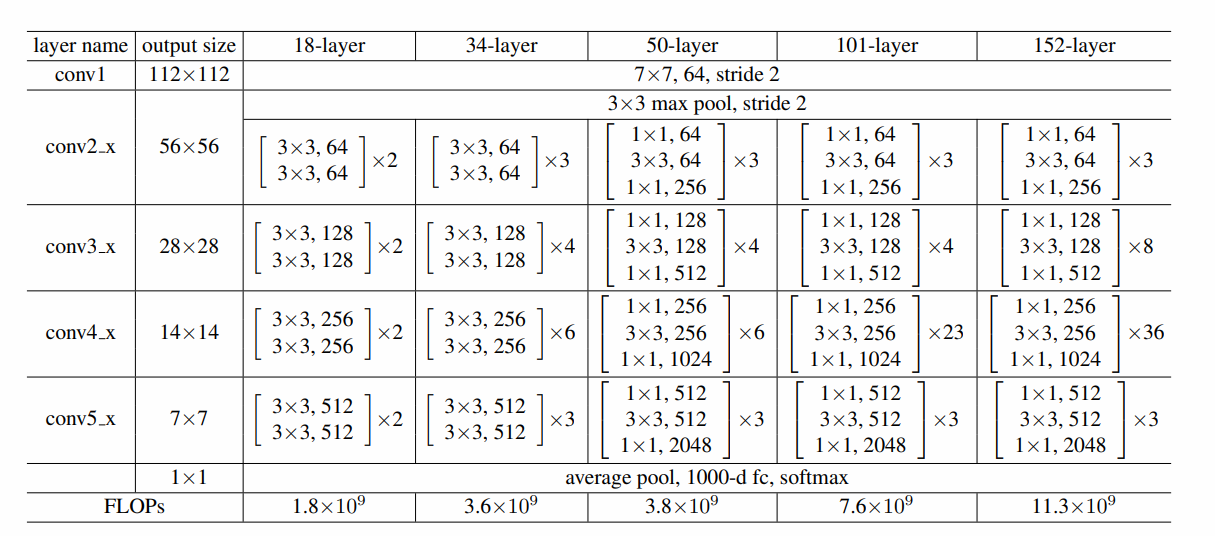

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class BasicBlock(nn.Module): # 18 34
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.LeakyReLU()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module): # 50 101 152
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.LeakyReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=4, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        # 어떤 이미지를 넣어줘도 AdaptiveAvgPool2d 을 사용하면 512 x 1 x 1 로 맞춰줌.
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
model = resnet101()
model.to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, CFG['IMG_SIZE_H'], CFG['IMG_SIZE_W'])) # 800 1200

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 600]           9,408
       BatchNorm2d-2         [-1, 64, 400, 600]             128
         LeakyReLU-3         [-1, 64, 400, 600]               0
         MaxPool2d-4         [-1, 64, 200, 300]               0
            Conv2d-5         [-1, 64, 200, 300]           4,096
       BatchNorm2d-6         [-1, 64, 200, 300]             128
         LeakyReLU-7         [-1, 64, 200, 300]               0
            Conv2d-8         [-1, 64, 200, 300]          36,864
       BatchNorm2d-9         [-1, 64, 200, 300]             128
        LeakyReLU-10         [-1, 64, 200, 300]               0
           Conv2d-11        [-1, 256, 200, 300]          16,384
      BatchNorm2d-12        [-1, 256, 200, 300]             512
           Conv2d-13        [-1, 256, 200, 300]          16,384
      BatchNorm2d-14        [-1, 256, 2

# 손실함수, 옵티마이저, 학습률, 학습 스케쥴러

In [ ]:
learning_rate = CFG['LEARNING_RATE'] #learning_rate=0.0001
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=CFG['SCHEDULER'], factor=0.1, verbose=True) # patience=6

# 모델 훈련

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
writer = SummaryWriter()

def validation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    with torch.no_grad():
        for images, labels in testloader: 
            images, labels = images.to(device), labels.to(device)
            
            logits = model.forward(images)
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            
            # roc_auc_score 위해 추가.
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()


            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)
            
            _, preds = torch.max(probs, 1)
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy

        test_auc = roc_auc_score(true_onehot_list, pred_list)
    return test_loss, test_accuracy, test_auc     

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

vali_acc=[]
vali_loss=[]

def train(model, epochs, criterion, optimizer):
    global vali_acc, vali_loss
    steps = 0
 
    iter_per_epoch = len(train_loader) 
    print_every = iter_per_epoch
    best_auc = 0
    valid_auc = 0

    min_loss = 1000
    trigger = 0
    patience = CFG['PATIENCE'] # patience=14


    valid_loss = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(iter(train_loader)):
            steps += 1
            images, labels = images.to(device), labels.to(device)

            
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step() 

            train_loss += loss.item()
            
            if steps % print_every == 0 : 
                model.eval()
                valid_loss, valid_accuracy, valid_auc = validation(model, vali_loader, criterion)
                
                vali_acc.append(valid_accuracy/len(vali_loader))
                vali_loss.append(valid_loss/len(vali_loader))

                writer.add_scalar("Loss/train", train_loss/len(train_loader), epoch)
                writer.add_scalar("Loss/test", valid_loss/len(vali_loader), epoch)
                writer.add_scalars("Loss/train and valid",
                                { "train" : train_loss/len(train_loader),
                                    "test" : valid_loss/len(vali_loader) }, epoch)
                writer.add_scalar("test_roc_auc", valid_auc, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                    " Train Loss : {:.3f}".format(train_loss/len(train_loader) ),
                    " Valid Loss : {:.3f}".format(valid_loss/len(vali_loader)),
                    " Valid Accuracy : {:.3f}".format(valid_accuracy/len(vali_loader)),
                    " Valid AUC_ROC :  {:.3f}".format(valid_auc))
                
                # Early stopping Start 
                if valid_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        writer.flush()
                        writer.close() 
                        return
                else: 
                    min_loss = valid_loss
                    trigger = 0
                
                # Early stopping End
                train_loss = 0
                model.train()
            # Best model 저장
            if valid_auc >= best_auc:
                torch.save(model.state_dict(), dir+"best_model_resnet.pth")
                best_auc = valid_auc
            

        # Learning Rate Scheduler 
        scheduler.step(valid_loss)
    writer.flush()
    writer.close()        

In [ ]:
train(model, CFG['EPOCHS'], criterion, optimizer) # epoch = 150

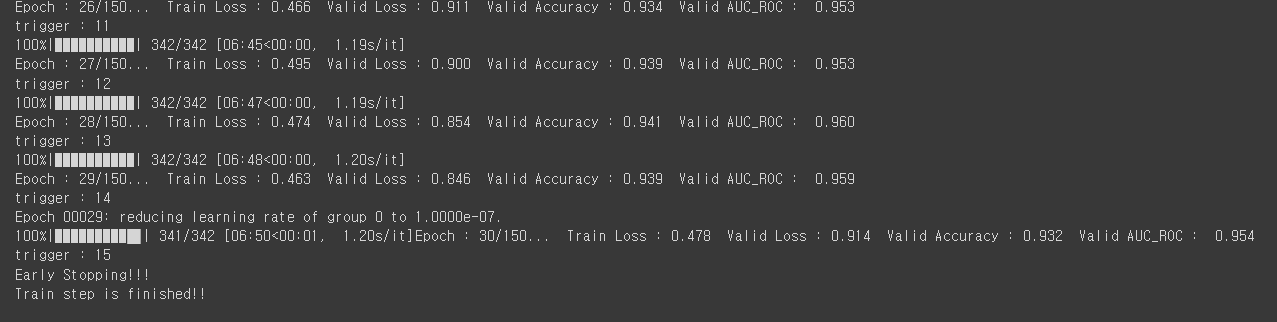

# 모델 평가

## valid 데이터 성능 측정

In [ ]:
def evaluate_v(model, testloader):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device)
            # not Flatten!
            #images.resize_(images.shape[0], 784) # batch size x 784
            logits = model.forward(images) # 입력 : batch * height * width
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]

            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy.item()

        test_auc = roc_auc_score(true_onehot_list, pred_list)
    print("Test Loss : ", test_loss/len(testloader))
    print("Accuracy : ", test_accuracy/len(testloader))
    print("AUC_ROC : ", test_auc)

## test 데이터 성능 측정

In [ ]:
def evaluate_t(model, testloader):
    test_accuracy = 0
    preds_test = np.zeros((len(test_img_path), 4))

    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for i, images in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            # Target Prediction Probability
            probs = F.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_test[i*CFG['BATCH_SIZE']:(i+1)*CFG['BATCH_SIZE']] += probs

    return preds_test

## 측정을 위해 모델을 불러오기

In [ ]:
torch.save(model.state_dict(), dir+"last_checkpoint_resnet.pth")
state_dict = torch.load(dir+"last_checkpoint_resnet.pth") 
last_model = resnet101() 
last_model.to(device)
last_model.load_state_dict(state_dict) 
test_preds=evaluate_t(last_model, test_loader)

In [ ]:
evaluate_v(last_model, vali_loader)

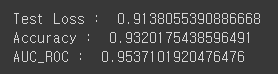

## test 데이터 셋 불러오기

In [ ]:
submission = pd.read_csv('./plant-pathology/sample_submission.csv')

In [ ]:
submission_test = submission.copy()
submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_preds
submission_test.to_csv('submission.csv', index=False)best_model

In [ ]:
evaluate_v(best_model, vali_loader)

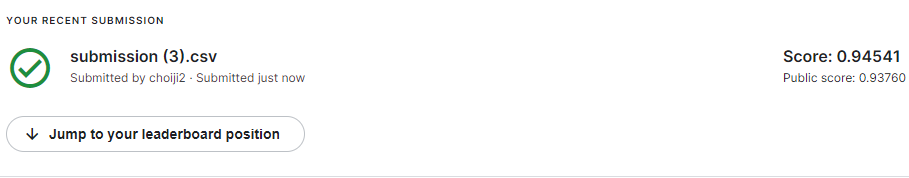

## best_model 일때의 성능측정

In [ ]:
state_dict = torch.load(dir +"best_model_resnet.pth") 
best_model = resnet101()
best_model.to(device)
best_model.load_state_dict(state_dict)
test_preds=evaluate_t(best_model, test_loader)

In [ ]:
submission_test2 = submission.copy()
submission_test2[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_preds
submission_test2.to_csv('submission2.csv', index=False)

In [ ]:
evaluate_v(best_model, vali_loader)

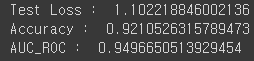

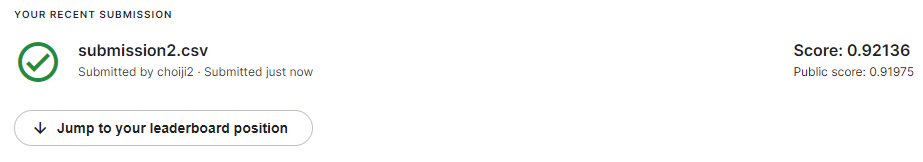

# QnA

- Q1) 어떤 옵티마이저, 로스 함수를 사용했는지?
    - adam, CrossEntropyLoss 를 사용 했습니다!

- Q2) 처음 시도했던 Network Architecture는 어떤 종류인지?
    - VGG19 입니다.
    - 이때 transform을 미실시 하였으며 처음 이미지 사이즈는 224x224로 설정 했습니다.

```
from torch import nn
from torch import optim
from torch.nn.modules.dropout import Dropout
import torch.nn.functional as F

cfg = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']

class VGG19(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = self.makemodel_(cfg)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=256), nn.LeakyReLU(),          
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128), nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=4),            
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

    def makemodel_(self, cfg):
        layers = []
        in_channels=3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(num_features=x),
                            nn.Dropout2d(0.2, inplace=True),
                            nn.LeakyReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=7, stride=7)]

        # 64*224*224  >  64*112*112
        # 64*112*112  >  128*56*56
        # 128*56*56   >  256*28*28 
        # 256*28*28   >  512*14*14 
        # 512*14*14   >  512*7*7
        # 512*7*7     >  512*1*1
        return nn.Sequential(*layers)
```

- Q3) 이후 시도해봤던 Network 들은 무엇인지?


- 간단 CNN
- 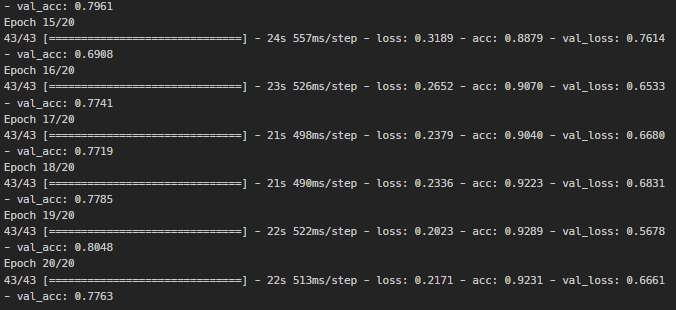

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(64,(3,3),strides=2,activation='relu',input_shape=(256,256,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128,(3,3),strides=2,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4,activation='softmax'))

- resnet 34
- 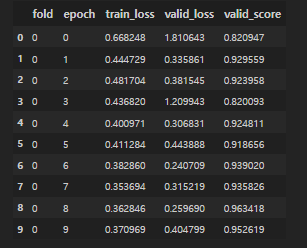

In [ ]:
model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')
in_features = model.last_linear.in_features
model.last_linear = nn.Linear(in_features, 4)

- EfficientNet_b0
- 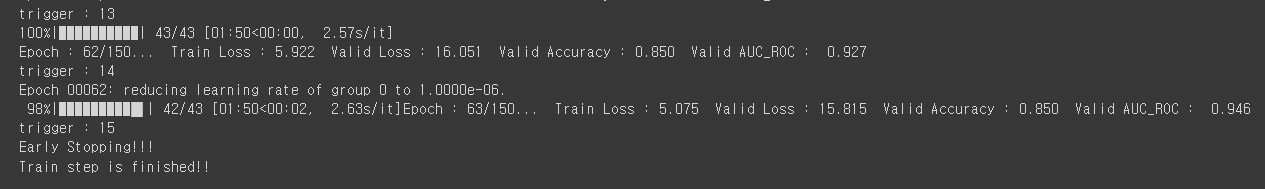

    - 코드는 추후 깃허브에 올릴 예정

- Q4) 과대적합을 피하기 위해 했던 작업들은 무엇인지?
	- train데이터를 변환하여 데이터를 변환해 주었습니다.

- Q5) 중요 하이퍼파라미터 어떻게 설정했는지? 이유?
           (배치사이즈(batch size), 에폭(epoch), 학습률(learning rate) 등)
	최초 batch_size = 32
		  image_size = 224 x 224
	      epoch = 43
 	      learning rate = 0.0001
		  schedulert = 6
		  early_stop = 14
	최종 batch_size = 4
		  image_size = 800 x 1200
	      epoch = 150
 	      learning rate = 0.0001
		  schedulert = 6
		  early_stop = 14

# 모델 참고.

- vgg, resnet
    - https://github.com/kuangliu/pytorch-cifar/tree/master/models 
- efficientNet
    - https://deep-learning-study.tistory.com/563